#### Import Libraries ####

In [1]:
import numpy as np
import json as json
import pandas as pd
import math
import datetime
import warnings
warnings.filterwarnings("ignore")
import pylab as pl 

In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)

#### Functions ####

In [3]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
def remove_outliers(sensor_data, sigma=0.25):
    """ 
    Eliminate likely sensor errors (outliers outside of sigma). Return Series not containing samples that 
    exceed +- sigma
    """
    # Compute mean and std
    mean = sensor_data.mean()
    std = sensor_data.std()
    # Define thresholds
    lower = mean - sigma * std
    upper = mean + sigma * std
    # Apply mask
    return sensor_data[(sensor_data >= lower) & (sensor_data <= upper)]

#### Read settings ####

In [5]:
config=json.loads(open('settings.json','r').read())

In [6]:
window = config['window'] # length of observation frame (in secs)
sample_rate = config['sample_rate'] # Hz
offset_x = config['offset_x']
offset_y = config['offset_y']
offset_z = config['offset_z'] # run calibrate.py to update this value, with sensor board resting as horizontal as possible
ipmux_addr = config['ipmux_addr']  # destination of NMEA UDP messages 
ipmux_port = config['ipmux_port'] 
pitch_on_y_axis = config['pitch_on_y_axis'] # Rpi oriented with longest side parallel to fore-aft line of vessel (0) or perpendicular (1)

sample_period = 1.0/sample_rate
n = int(window*sample_rate) 
df = float(sample_rate)/float(n)

## Sensor Logs ##

Read CSV

In [7]:
logs = pd.read_csv('log_sec.csv', index_col = False)
logs["datetime"] = pd.to_datetime(logs["timestamp"], unit="s")#.dt.strftime('%Y-%m-%d %H:%M:%S')
logs['pressure'] = logs.pressure.astype(int)
logs.drop(logs[['timestamp','date', 'time']], axis=1, inplace=True)
logs

,temperature,pressure,humidity,avg_pitch_,avg_roll,max_pitch,max_roll,wave height,wave period,datetime
0,40.233,1016,66.766,1.4,1.1,0,0,0.0000,0.0000,2025-09-01 22:54:12.902529955
1,40.290,1016,67.005,1.2,1.7,0,0,0.1458,6.0000,2025-09-01 22:57:12.990880013
2,40.452,1016,66.432,1.0,1.0,0,0,0.1431,4.8649,2025-09-01 23:00:13.079780102
3,40.412,1016,66.043,0.7,1.5,0,0,0.2831,4.8649,2025-09-01 23:03:13.168780088
4,40.365,1016,65.915,0.6,1.4,0,0,0.3680,18.0000,2025-09-01 23:06:13.257980108
...,...,...,...,...,...,...,...,...,...,...
593,33.000,1007,77.000,0.0,0.0,0,1,0.0000,0.0000,2025-09-09 21:02:33.881999969
594,33.000,1007,77.000,0.0,1.0,1,2,0.0000,0.0000,2025-09-09 21:05:33.961999893
595,33.000,1007,77.000,0.0,1.0,0,3,0.0000,0.0000,2025-09-09 21:08:34.038000107
596,33.000,1007,77.000,0.0,0.0,1,2,0.0000,0.0000,2025-09-09 21:11:34.140000105


Filter on datetime

In [8]:
time_ago = datetime.datetime.now() - datetime.timedelta(days=1)
logs = logs[logs['datetime'] >= time_ago]

reindex on datetime

In [9]:
logs.set_index('datetime', inplace=True)

### Raw Plots ###

#### Humidity ####

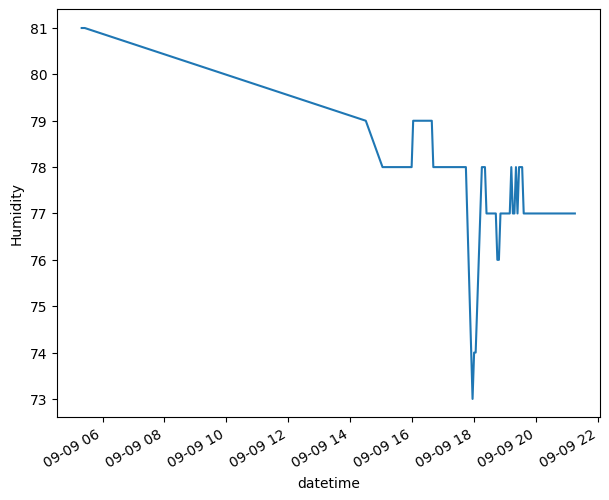

In [29]:
pl.ylabel('Humidity')
logs['humidity'].plot(figsize=[7,6])
pl.show()

#### Pressure ####

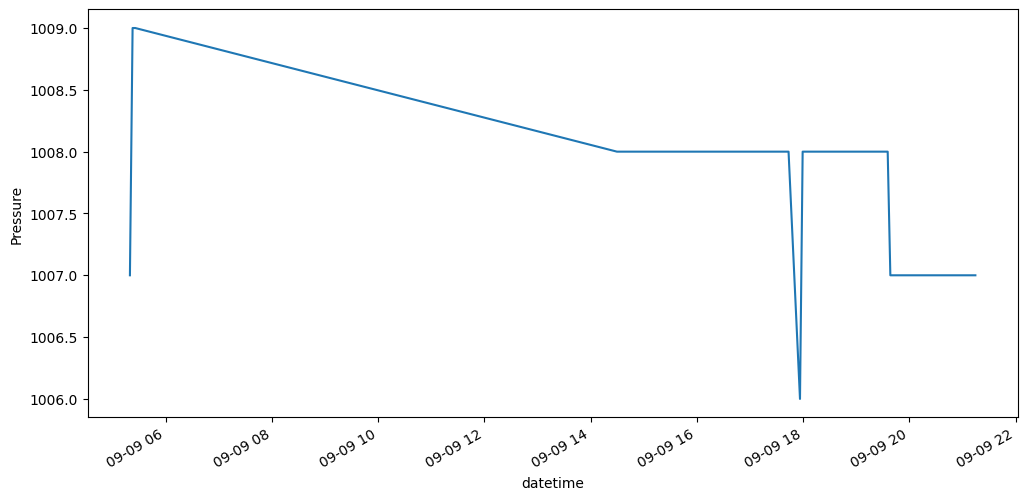

In [10]:
pl.ylabel('Pressure')
logs['pressure'].plot(figsize=[12,6])
pl.show()

#### Wave Height ####

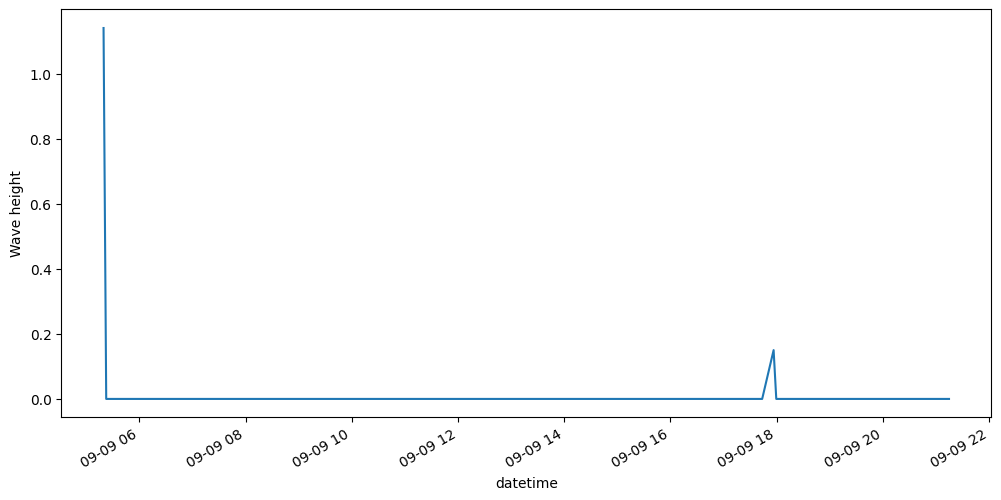

In [25]:
pl.ylabel('Wave height')
logs['wave height'].plot(figsize=[12,6])
pl.show()

### Hourly Plots ###

In [11]:
hourly_logs = logs.resample('h').mean()

#### Hourly Humidity ###

resample() fills in missing datapoints with NaN values, which cause gaps in the chart. We use dropna() to eliminate those.

<Axes: xlabel='datetime', ylabel='Humidity'>

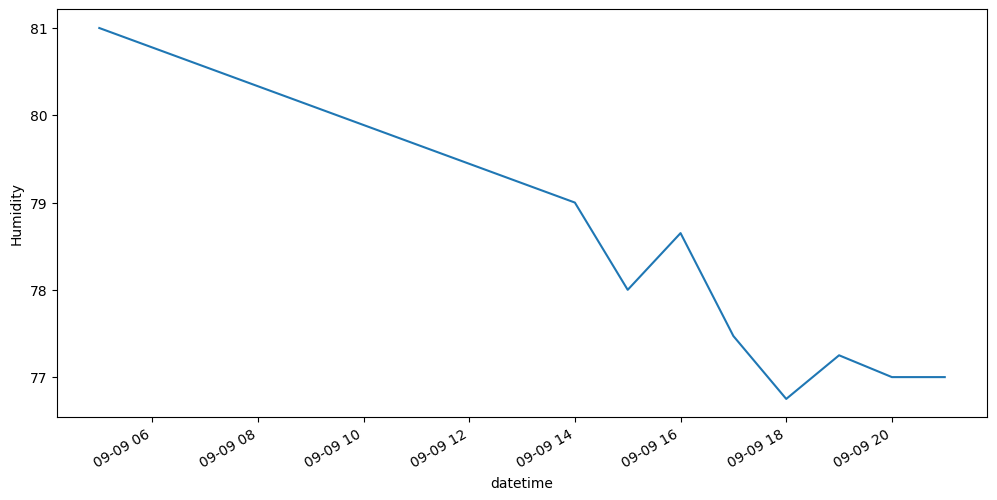

In [12]:
pl.ylabel('Humidity')
hourly_logs['humidity'].dropna().plot(figsize=[12,6])

#### Hourly Pressure ####

<Axes: xlabel='datetime', ylabel='Pressure'>

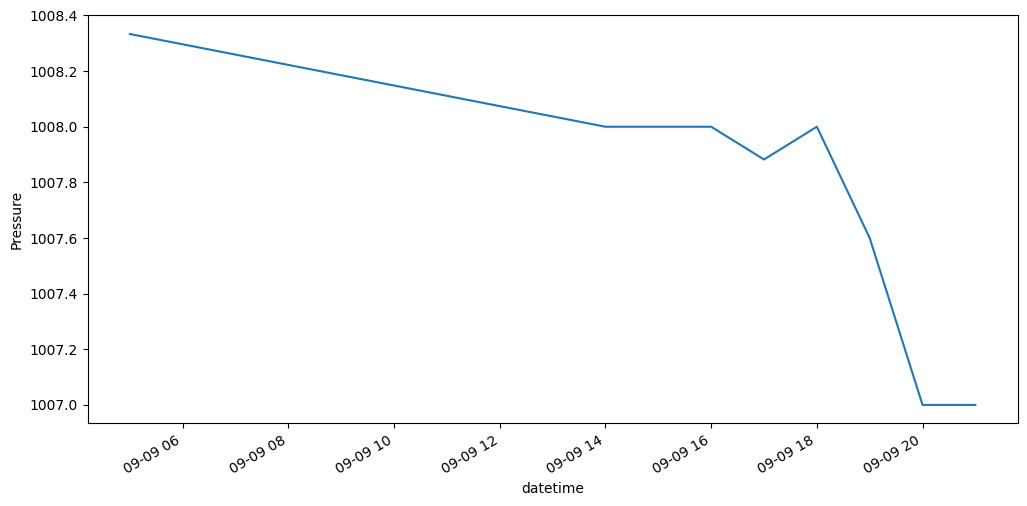

In [13]:
pl.ylabel('Pressure')
hourly_logs['pressure'].dropna().plot(figsize=[12,6])

## NMEA logs ##

In [14]:
nm_logs = pd.read_csv('log_nmea.csv', index_col = False)

In [15]:
nm_logs["datetime"] = pd.to_datetime(nm_logs["timestamp"], unit="s")
#logs.drop(logs[['timestamp','date', 'time']], axis=1, inplace=True)
#nm_logs = nm_logs[["datetime","lat","lon","sog_kts","cog","hdg","hdg_mag","hdg_true","wind_sp_kts","wind_angle","depth_ft", "depth_m", "water_temp_c"]]
#nm_logs.style.format({'datetime': lambda x: "{}".format(x.strftime('%Y-%m-%d %H:%M:%S'))})
nm_logs

,timestamp,lat,lon,sog_kts,cog,hdg,hdg_mag,hdg_true,wind_sp_kts,wind_angle,depth_ft,depth_m,water_temp_c,datetime
0,1.756941e+09,37.516,-122.289,0.000,95,116,116,85,10.33,131,10.33,3.15,0,2025-09-03 23:11:31.134000063
1,1.756941e+09,37.516,-122.289,0.000,353,116,116,85,11.25,134,10.31,3.14,0,2025-09-03 23:12:31.345999956
2,1.756941e+09,37.516,-122.289,0.000,356,116,116,84,15.19,132,14.81,4.51,0,2025-09-03 23:13:31.559000015
3,1.756941e+09,37.516,-122.289,0.000,10,116,116,85,15.69,118,10.50,3.20,0,2025-09-03 23:14:31.565999985
4,1.756941e+09,37.516,-122.289,0.000,11,116,116,84,10.27,123,10.45,3.18,0,2025-09-03 23:15:31.575000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,1.757006e+09,37.516,-122.289,0.000,114,116,116,85,7.27,134,11.27,3.44,0,2025-09-04 17:18:59.809000015
104,1.757006e+09,37.516,-122.289,0.013,66,116,116,85,6.46,128,11.49,3.51,0,2025-09-04 17:19:59.845000029
105,1.757007e+09,37.516,-122.289,0.042,56,115,115,86,7.44,157,10.42,3.18,0,2025-09-04 17:21:58.428999901
106,1.757007e+09,37.516,-122.289,0.000,96,116,116,86,5.93,140,11.09,3.38,0,2025-09-04 17:22:58.917999983


Filter on Datetime

In [16]:
time_ago = datetime.datetime.now() - datetime.timedelta(days=10)
nm_logs = nm_logs[nm_logs['datetime'] >= time_ago]

Index on Datetime

In [17]:
nm_logs.set_index('datetime', inplace=True)

### Raw plots ###

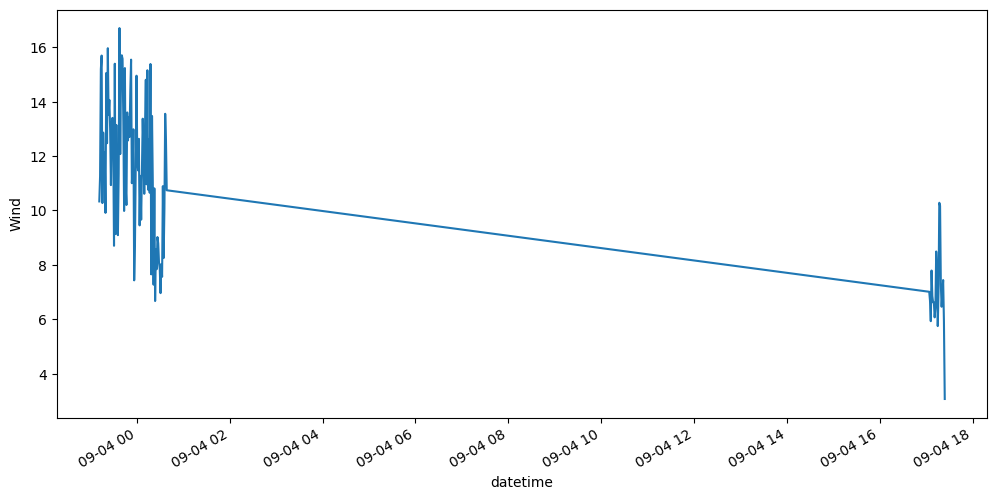

In [18]:
pl.ylabel('Wind')
nm_logs['wind_sp_kts'].plot(figsize=[12,6])
pl.show()

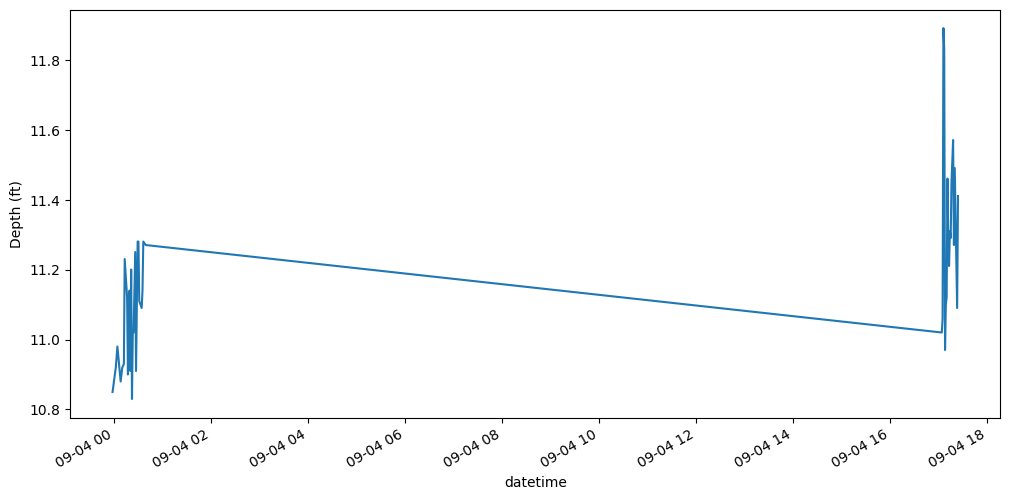

In [19]:
pl.ylabel('Depth (ft)')
cleaned_data  = remove_outliers(nm_logs['depth_ft'], sigma = .3)
cleaned_data.plot(figsize=[12,6])
pl.show()

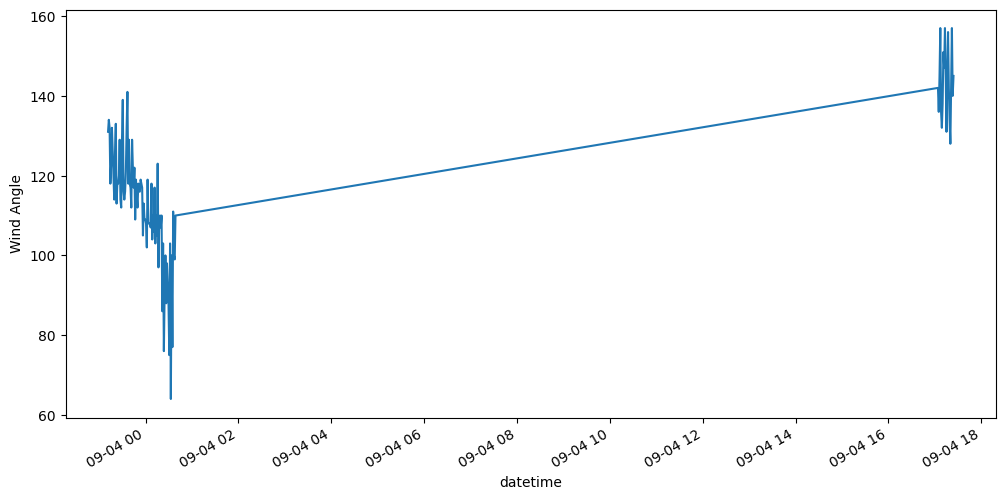

In [20]:
pl.ylabel('Wind Angle')
nm_logs['wind_angle'].plot(figsize=[12,6])
pl.show()

### Hourly Plots ###

In [21]:
hourly_nm_logs = nm_logs.resample('h').mean()

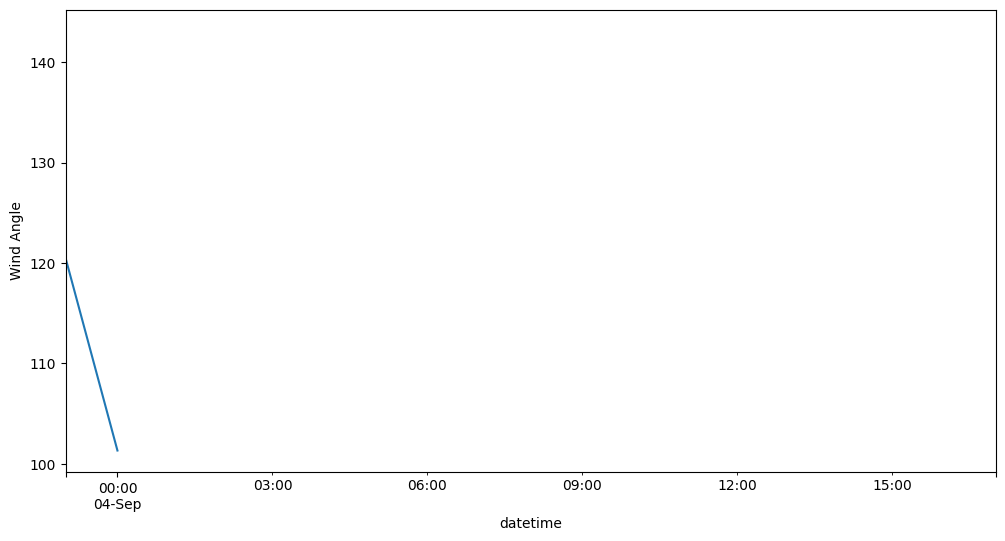

In [22]:
pl.ylabel('Wind Angle')
hourly_nm_logs['wind_angle'].plot(figsize=[12,6])
pl.show()

## Debugging ##

In [23]:
npydir = 'npyfiles/'
run = '2025_09_02_00_24' # manual simulation of about 1 mt oscillations

In [24]:
freqs    = np.load(f'{npydir}freqs_{run}.npy')
signal   = np.load(f'{npydir}signal_{run}.npy')
amp_spec = np.load(f'{npydir}amp_spec_{run}.npy')
heights  = np.load(f'{npydir}heights_{run}.npy')
print('signal: ', len(signal), 'amp_spec: ', len(amp_spec))

FileNotFoundError: [Errno 2] No such file or directory: 'npyfiles/freqs_2025_09_02_00_24.npy'

In [ ]:
#signal = np.load(f'{npydir}signal_corr.npy')

In [ ]:
w=40
mavg_signal = moving_average(signal,w)
ls =  len(signal)
print(len(signal),len(mavg_signal))

In [ ]:
pl.title('Signal Moving Avg')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(w, ls-w )],mavg_signal[w:ls-w])
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal[0:ls])
pl.show()

subtract moving average from signal to clean low frequencies

In [ ]:
signal_corr = np.concatenate([signal[:w-1], signal[w-1:]-mavg_signal] )

In [ ]:
pl.title('Signal Corr')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal_corr[0:ls])
pl.show()

In [ ]:
np.save(f'{npydir}signal_corr', signal_corr)

In [ ]:
pl.title('Acceleration spectrum')
pl.xlabel('Freq (Hz)')
pl.ylabel('accel (m/sec2)')
pl.plot(freqs, amp_spec)
pl.show()

In [ ]:
w=4
mavg = moving_average(amp_spec, w)
max_index = np.argmax(mavg)+int(w/2)
dom_freq = freqs[max_index]
dom_per = 1/dom_freq
dom_per

In [ ]:
mavg = pl.plot(freqs[3:], mavg)

In [ ]:
pl.title('Displacement Frequency Spectrum')
pl.xlabel('freq (Hz)')
pl.ylabel('height (mt)')
pl.plot(freqs, heights)
pl.show()

In [ ]:
avg_acc = sum(amp_spec)/(len(amp_spec))
avg_acc

In [ ]:
heights[2:]

In [ ]:
max_index = np.argmax(heights[2:])
max_index

Power spectral density

In [ ]:
psd = (heights[2:]**2)/freqs[2:]
psd

In [ ]:
m0  = sum(psd*df)
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height

Amplitude Spectral Density

In [ ]:
asd = np.sqrt(psd)

In [ ]:
m0  = sum(asd*df)
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height

#### calculate SWH from time series ####

this makes no sense as it is calculated on acceleration, not displacement

In [ ]:
m0 = np.var(signal)

In [ ]:
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height